# Code to import files from Google Drive folders

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Necessary Library Imports
Notes and code above this are for reference

In [ ]:
!pip install mpltools
!pip install essentia
import essentia.standard as es

  Preparing metadata (setup.py) ... done
  Created wheel for mpltools: filename=mpltools-0.2.0-py3-none-any.whl size=35679 sha256=8f429742d994378f011bad84fa07c59fe60cb18e0a684cf781857cf86c26a775
  Stored in directory: /root/.cache/pip/wheels/da/f9/f8/62ee15317bd486aa16e2dd4dc3713e35dec12d384a45665f0f
Successfully built mpltools
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 113.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

from mpltools import layout

## Loading File in as numpy array

Convert _.csv_ file to pandas dataframe

In [ ]:
from google.colab import files
ecg_proj_file = files.upload()

dataframe = pd.read_csv(r'ECG115.csv', header=None)
ecg_data = dataframe[0].to_numpy()

## Data details

In [ ]:
Fs = 360 # Sampling frequency - 360Hz
num_datapoints = len(ecg_data)
mins_of_data = num_datapoints/(Fs*60)
print(f"{mins_of_data} minutes of data available")

30.09259259259259 minutes of data available


# Summary
This assignment focuses on the analysis of ECG signal data from the MIT-BIH Arrhythmia Database. The primary objectives including implenting high and low pass filters to remove unwanted noise to prepare the signal for R-R peak detection via the Pan Tompkins method.

The aim of the Pan Tompkins algorithm is to detect the R-R intervals as seen in the diagram below. Firstly the signal must be filtered to remove the unwanted noise components. The most common noise components of ECG data being:

- Muscle Noise
- Mains Interference
- Baseline Wander
- T-Wave Interference

The desired frequency range lies between 5 - 15 Hz. In order to achieve this a cascade of high and low pass filters are used. Both High and Low pass filters use the blackman window in order to achieve ideal stop band attenuation. The high pass filter has a filter length of _1981_ to achieve a 1 Hz transition bandwidth, and the low pass filter a filter length of _991_ for a transition bandwidth of 2 Hz.

These filters introduce time delays of 2.75 seconds and 1.38 seconds respectively. This method was chosen despite the time delays as this case does not employ real time filtering. If real time filtering were necessary the time delays may be unacceptable  

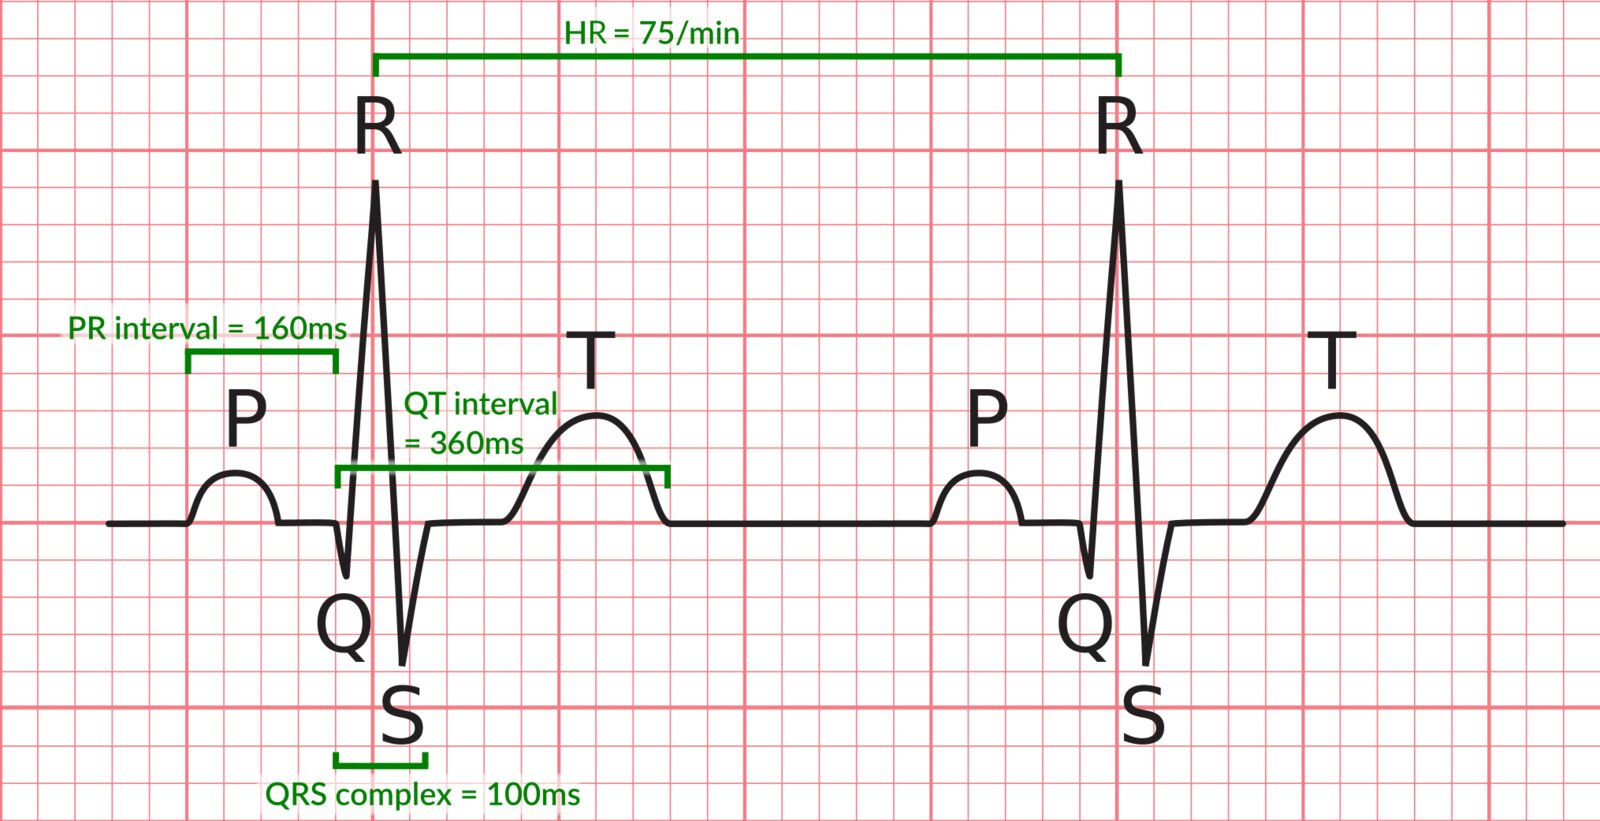

# Composition of Input signal


It can be seen from the section of ECG data below that the data shows the characteristic ECG peaks as seen in the diagram above.

<Axes: title={'center': 'ECG Data'}, xlabel='$n$', ylabel='$\\mu$ volts'>

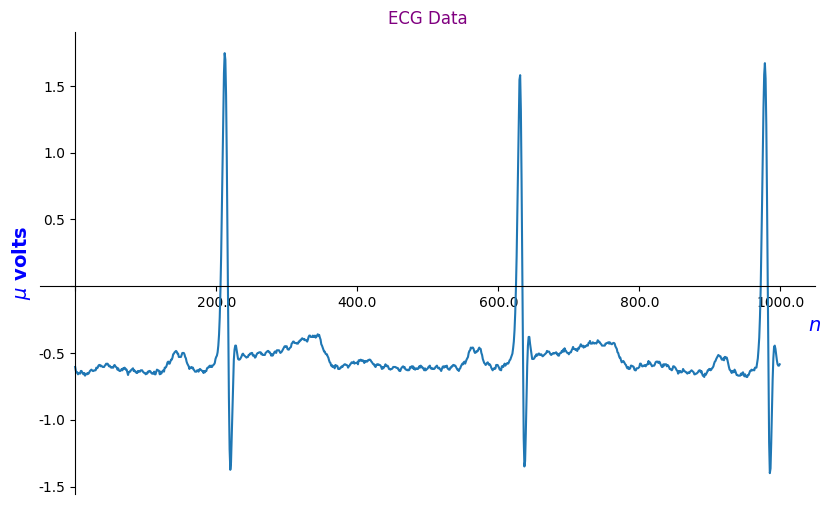

In [ ]:
plt.figure(figsize = (10,6)) # 10 in by 6 in
plt.plot(ecg_data[1000:2000])
plt.title("ECG Data", color ="purple")
plt.ylabel('$\mu$ volts', fontsize=14, color="blue", weight="bold")
plt.xlabel('$n$', fontsize=14, color="blue", weight="bold",  x=1.0)
layout.cross_spines(zero_cross=True)

## Spectral estimation

The decision was made to use the scipy welch function in order to determine the spectral contents of the signal.

The welch function uses windowing and averaging together to help reduce the bias and variance while not compromising the resolution in spectral estimation.

Here, Welch's method was used with a segment length of 1024 and 50% overlap, utilising a hamming window to smooth the data.

In [ ]:
f_ecg, ecg_welchperiodogram = signal.welch(ecg_data, Fs, 'hamming', nperseg=1024, detrend=False)

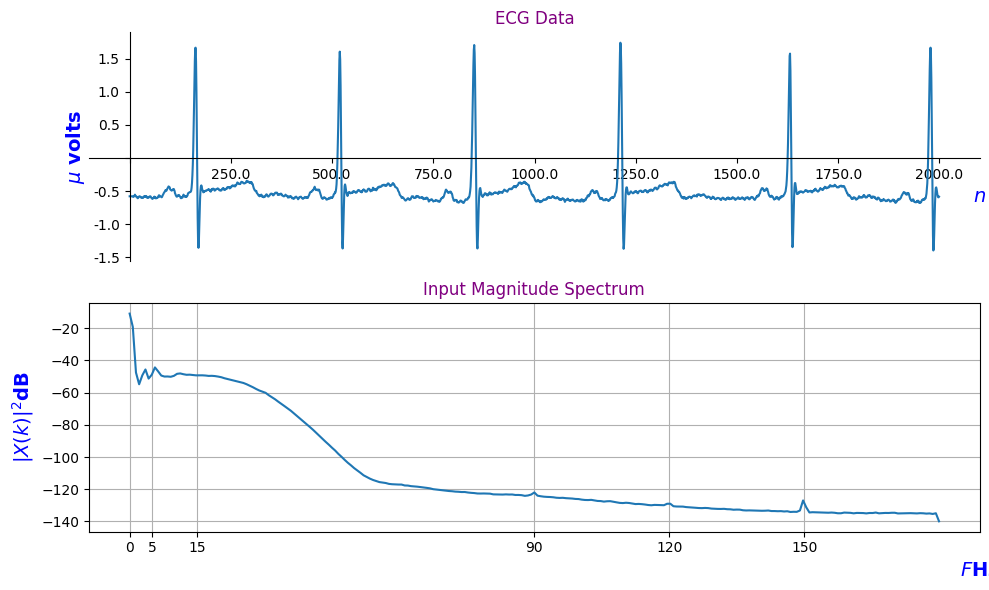

In [ ]:
plt.figure(figsize = (10,6)) # 10 in by 6 in
plt.subplot(211)
plt.plot(ecg_data[0:2000]) # Show 5.6 seconds of data
plt.title("ECG Data", color ="purple")
plt.ylabel('$\mu$ volts', fontsize=14, color="blue", weight="bold")
plt.xlabel('$n$', fontsize=14, color="blue", weight="bold",  x=1.0)
layout.cross_spines(zero_cross=True)
# plt.grid(True)

plt.subplot(212)
plt.plot(f_ecg, 20*np.log10(ecg_welchperiodogram))
plt.title("Input Magnitude Spectrum", color ="purple")
plt.ylabel('$|X(k)|^2$dB', fontsize=14, color="blue", weight="bold")
plt.xlabel('$F$Hz', fontsize=14, color="blue", weight="bold",  x=1.0)
plt.xticks([0,5,15,90,120,150])
plt.tight_layout() # ensure sufficient spacing between subplots
plt.grid(True)


It can be seen from the Input magnitude spectrum the various sources of noise

- **Muscle Noise:** usually occurs at around 10% of the ECG Amplitude in the 20 - 1000Hz Frequency Range
- **Mains Interference:** Usually seen around 50/60Hz
- **Baseline Wander:** Can be seen within the 0.05 - 1Hz Region

It can also be seen that there are small peaks at around 90Hz, 120Hz and 150Hz.

# Filter Design

## High Pass Filter Design

From the plots above it is interesting to note the large DC component in the spectrum.  This is typically a result of baseline wander.  To remove this a high pass filter with a cutoff frequency of 5Hz was utilised.

The transition bandwidth was set to 1 Hz as the goal was to remove as much noise lower than 5Hz as possible

It is important to note that due to the inverse relationship between transition bandwidth and filter length, the shorter the bandwidth, the larger the filter and thus the more computationally intensive the filter.

The input parameters for this filter design method are the transition bandwidth, the desired cutoff frequency, and the window being utilised.

In [ ]:
deltaHPF = 1 # Transition Bandwidth in Hz
HPPassbandF = 5  # Passband Edge Frequency in Hz
FcHP = HPPassbandF - deltaHPF/2   # Cutoff Frequency in Hz

Here the filter size and performance of 4 different window types was investigated.

Each filter type requires a different M value to achieve the desired transition bandwidth according to the following specification

- **Rectangular** : Δf = 0.9 / M
- **Hanning** : Δf = 3.1 / M
- **Hamming** : Δf = 3.3 / M
- **Blackman** : Δf = 5.5 / M



In [ ]:
# Rectangular
M_rectangular = int(np.ceil(0.9 * Fs/deltaHPF)) # Filter Length for Blackman Window
M_rectangular = M_rectangular + 1 if M_rectangular % 2 == 0 else M_rectangular # Ensure filter length is odd
print(f"M_rectangular = {M_rectangular}")

# Hanning
M_hanning = int(np.ceil(3.1 * Fs/deltaHPF)) # Filter Length for Hanning Window
M_hanning = M_hanning + 1 if M_hanning % 2 == 0 else M_hanning # Ensure filter length is odd
print(f"M_hanning = {M_hanning}")

# Hamming
M_hamming = int(np.ceil(3.3 * Fs/deltaHPF)) # Filter Length for Hamming Window
M_hamming = M_hamming + 1 if M_hamming % 2 == 0 else M_hamming # Ensure filter length is odd
print(f"M_hamming = {M_hamming}")

# Blackman
M_blackman = int(np.ceil(5.5 * Fs/deltaHPF)) # Filter Length for Blackman Window
M_blackman = M_blackman + 1 if M_blackman % 2 == 0 else M_blackman # Ensure filter length is odd
print(f"M_blackman = {M_blackman}")

M_rectangular = 325
M_hanning = 1117
M_hamming = 1189
M_blackman = 1981


In [ ]:
MidM_rectangular = int((M_rectangular-1)/2)
print(f"MidM_rectangular = {MidM_rectangular}")

MidM_hanning = int((M_hanning-1)/2)
print(f"MidM_hanning = {MidM_hanning}")

MidM_hamming = int((M_hamming-1)/2)
print(f"MidM_hamming = {MidM_hamming}")

MidM_blackman = int((M_blackman-1)/2)
print(f"MidM_blackman = {MidM_blackman}")

MidM_rectangular = 162
MidM_hanning = 558
MidM_hamming = 594
MidM_blackman = 990


In [ ]:
# Calculate filter coefficients for each of the window types
ncoeffHP_rectangular = signal.firwin(M_rectangular, FcHP, window = 'boxcar', fs = Fs, pass_zero=False)

# Note: Hanning window not supported in scipy firwin function
# ncoeffHP = signal.firwin(M_hanning, FcHP, window = 'hanning', fs = Fs, pass_zero=False)

ncoeffHP_hamming = signal.firwin(M_hamming, FcHP, window = 'hamming', fs = Fs, pass_zero=False)

ncoeffHP_blackman = signal.firwin(M_blackman, FcHP, window = 'blackman', fs = Fs, pass_zero=False)

# Calculating frequency response of each of the filter types
w_rectangular, HWHP_rectangular = signal.freqz(ncoeffHP_rectangular, fs = Fs)

w_hamming, HWHP_hamming = signal.freqz(ncoeffHP_hamming, fs = Fs)

w_blackman, HWHP_blackman = signal.freqz(ncoeffHP_blackman, fs = Fs)

### Plotting Impulse  & Frequency Response

<ipython-input-17-b6a9cd425d90>:4: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(ncoeffHP_rectangular, linefmt='blue', markerfmt='ro', use_line_collection = True, basefmt=" ")
<ipython-input-17-b6a9cd425d90>:15: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(ncoeffHP_hamming, linefmt='blue', markerfmt='ro', use_line_collection = True, basefmt=" ")
<ipython-input-17-b6a9cd425d90>:26: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter fol

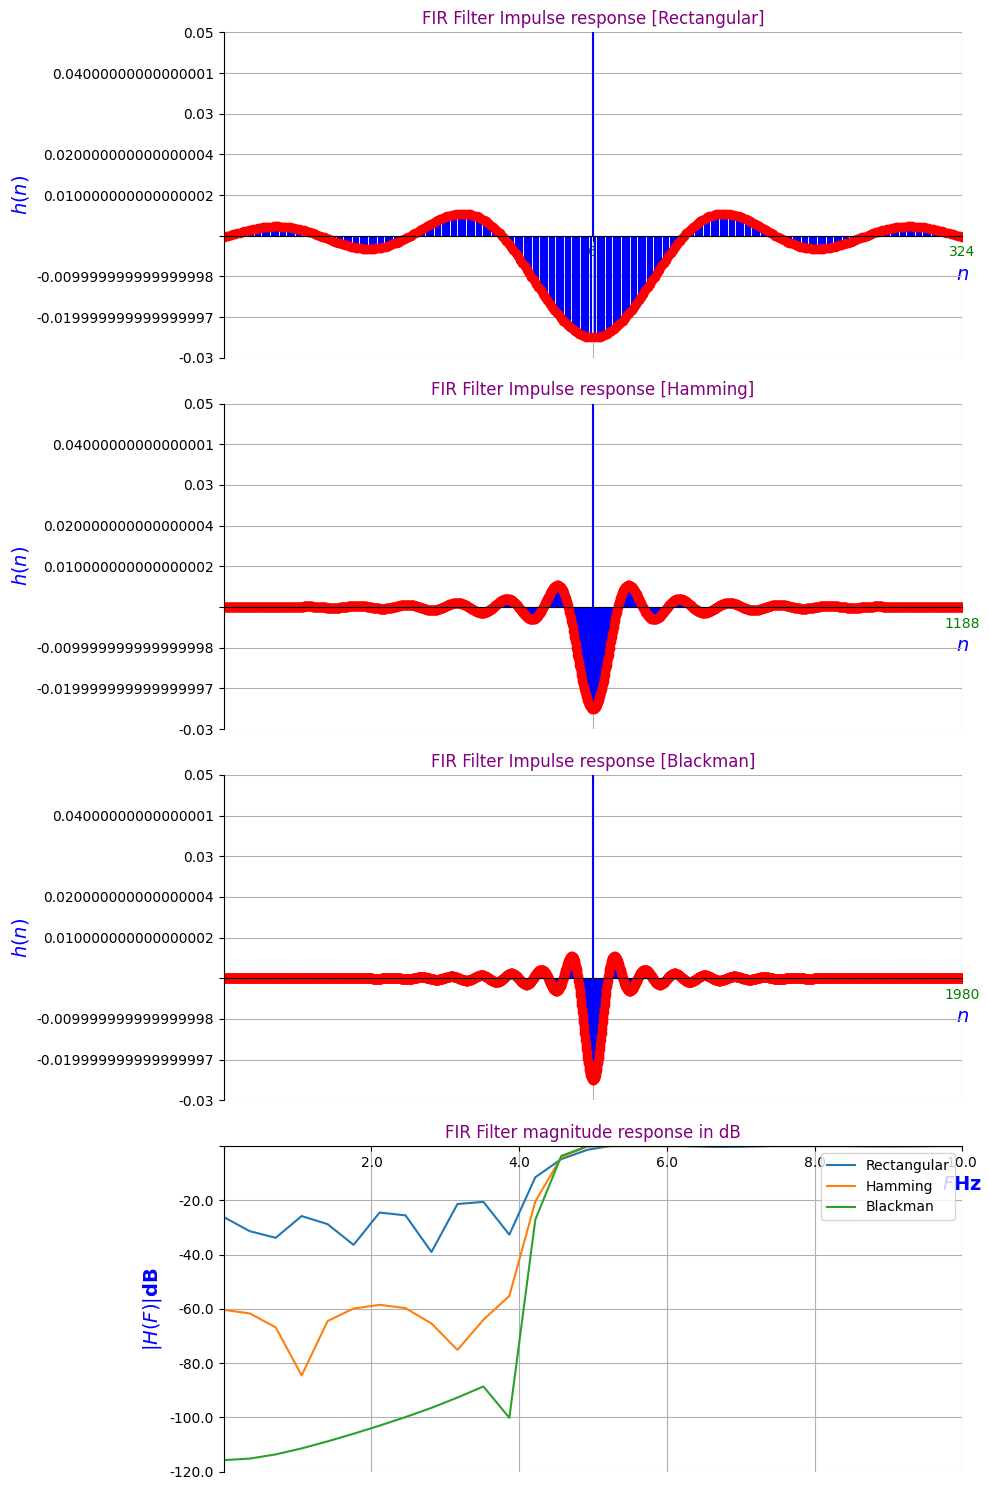

In [ ]:
plt.figure(figsize = (10,15))

plt.subplot(411)
plt.stem(ncoeffHP_rectangular, linefmt='blue', markerfmt='ro', use_line_collection = True, basefmt=" ")
plt.title("FIR Filter Impulse response [Rectangular]", color ="purple")
plt.ylabel('$h(n)$', fontsize=14, color="blue", weight="bold") # Could use rotation=0
plt.xlabel('$n$', fontsize=14, color="blue",  x=1.0)
layout.cross_spines(zero_cross=True)
plt.xticks([0,MidM_rectangular,M_rectangular-1], color="green")
# plt.yticks([0,1])
plt.axis([0,M_rectangular-1,-0.03,0.05])
plt.grid(True)

plt.subplot(412)
plt.stem(ncoeffHP_hamming, linefmt='blue', markerfmt='ro', use_line_collection = True, basefmt=" ")
plt.title("FIR Filter Impulse response [Hamming]", color ="purple")
plt.ylabel('$h(n)$', fontsize=14, color="blue", weight="bold") # Could use rotation=0
plt.xlabel('$n$', fontsize=14, color="blue",  x=1.0)
layout.cross_spines(zero_cross=True)
plt.xticks([0,MidM_hamming,M_hamming-1], color="green")
# plt.yticks([0,1])
plt.axis([0,M_hamming-1,-0.03,0.05])
plt.grid(True)

plt.subplot(413)
plt.stem(ncoeffHP_blackman, linefmt='blue', markerfmt='ro', use_line_collection = True, basefmt=" ")
plt.title("FIR Filter Impulse response [Blackman]", color ="purple")
plt.ylabel('$h(n)$', fontsize=14, color="blue", weight="bold") # Could use rotation=0
plt.xlabel('$n$', fontsize=14, color="blue",  x=1.0)
layout.cross_spines(zero_cross=True)
plt.xticks([0,MidM_blackman,M_blackman-1], color="green")
# plt.yticks([-0.01,0.048,0.05])
plt.axis([0,M_blackman-1,-0.03,0.05])
plt.grid(True)

plt.subplot(414)
plt.plot(w_rectangular,20*np.log10(np.abs(HWHP_rectangular)))
plt.plot(w_hamming,20*np.log10(np.abs(HWHP_hamming)))
plt.plot(w_blackman,20*np.log10(np.abs(HWHP_blackman)))
plt.title("FIR Filter magnitude response in dB", color ="purple")
plt.ylabel('$|H(F)|$dB', fontsize=14, color="blue", weight="bold")
plt.xlabel('$F$Hz', fontsize=14, color="blue", weight="bold",  x=1.0)
plt.legend(["Rectangular", "Hamming", "Blackman"])
layout.cross_spines(zero_cross=True)
plt.axis([0,10,-120,0])
# plt.yticks([-150,-125,-100,-75,-50,-25,-6,0])
# plt.xticks([5,125], color="green")
plt.tight_layout() # ensure sufficient spacing between subplots
plt.grid(True)


It was decided that the blackman filter provided the best filtering, however, this comes at the cost of increased filter length, increasing the number of computations necesary, and increasing the delay incurred by the filter.

The Blackman filter is longer than that of the rectangular filter by a factor of

\begin{align}
\frac{5.5}{0.9} ≃ 6.1
\end{align}

The length of the filter can also be reduced by increasing the transition bandwidth. For instance, by increasing the transition bandwidth to 2Hz the filter reduces in length by half.

In [ ]:
ecg_HPoutput = signal.lfilter(ncoeffHP_blackman, [1.0], ecg_data)

In [ ]:
f_HP, ecg_HPoutputwelch =  signal.welch(ecg_HPoutput, Fs, 'blackman', nperseg=1024, detrend=False)

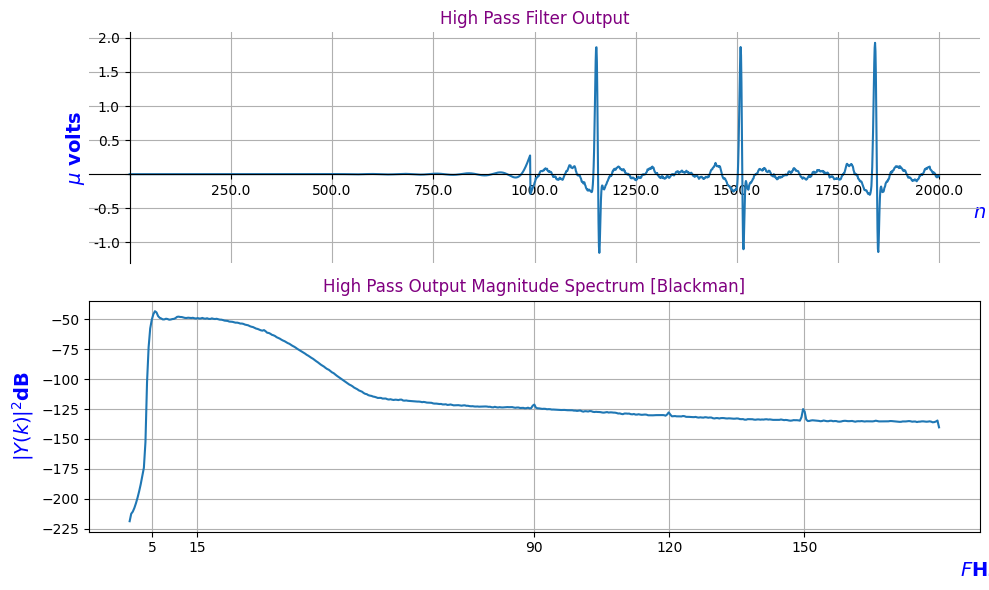

In [ ]:
plt.figure(figsize = (10,6)) # 10 in by 6 in
plt.subplot(211)
plt.plot(ecg_HPoutput[0:2000])
plt.title("High Pass Filter Output", color ="purple")
plt.ylabel('$\mu$ volts', fontsize=14, color="blue", weight="bold")
plt.xlabel('$n$', fontsize=14, color="blue", weight="bold",  x=1.0)
plt.grid(True)
layout.cross_spines(zero_cross=True)

plt.subplot(212)
plt.plot(f_HP, 20*np.log10(ecg_HPoutputwelch))
plt.title("High Pass Output Magnitude Spectrum [Blackman]", color ="purple")
plt.ylabel('$|Y(k)|^2$dB', fontsize=14, color="blue", weight="bold")
plt.xlabel('$F$Hz', fontsize=14, color="blue", weight="bold",  x=1.0)
plt.xticks([5,15,90,120,150])
# plt.axis([0, 125,-120,50])
plt.grid(True)
plt.tight_layout() # ensure sufficient spacing between subplots


It is important to note the latency of the output compared to the input as seen below. This latency is equal to $\frac{M-1}{2} = 990$ (where M is filter length).

The output after filtering can be shifted forward in time by $\frac{M-1}{2}$ samples to re-align with the origninal signal

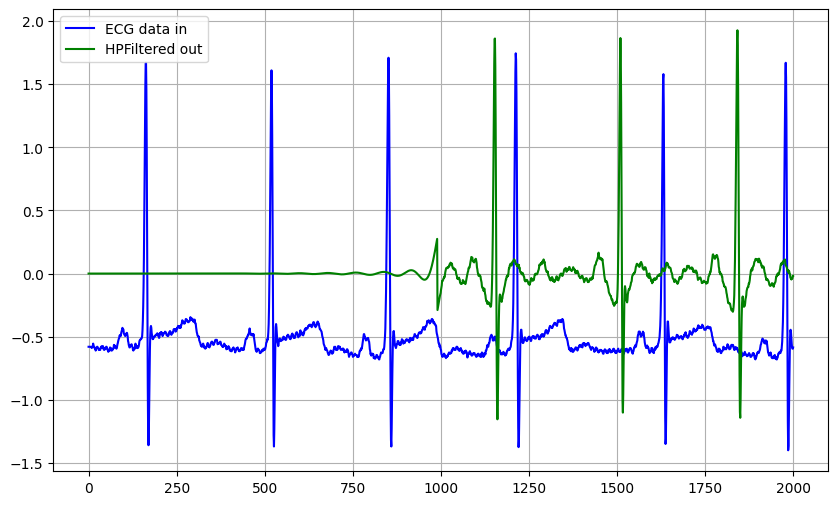

In [ ]:
plt.figure(figsize = (10,6)) # 10 in by 6 in
plt.title('Demonstrating the FIlter Latency');
plt.plot(ecg_data[0:2000], 'blue', label='ECG data in')
plt.plot(ecg_HPoutput[0:2000],'green', label='HPFiltered out');
plt.grid(True)
plt.legend();

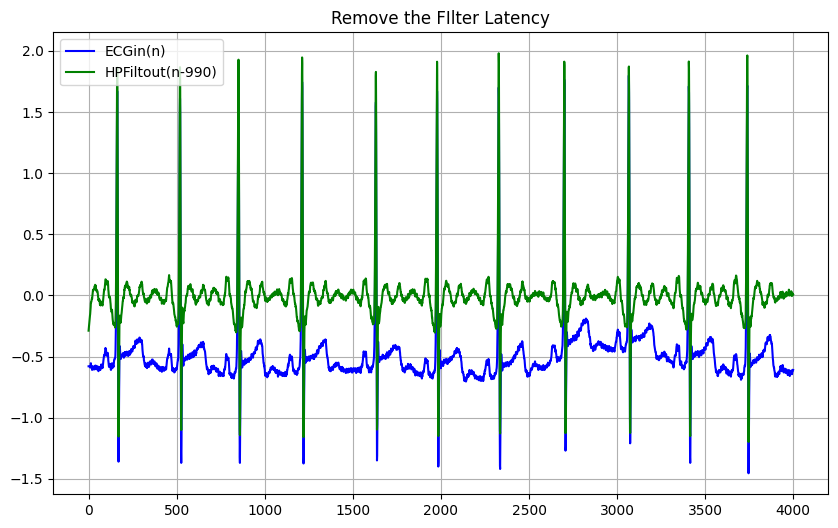

In [ ]:
plt.figure(figsize = (10,6)) # 10 in by 6 in
plt.plot(ecg_data[0:4000], 'blue',label='ECGin(n)');
plt.plot(ecg_HPoutput[MidM_blackman:4000+MidM_blackman],'green', label='HPFiltout(n-990)');
plt.title('Removing the FIlter Latency');
plt.grid(True)
plt.legend();

# Lowpass Filter Design

The process for Low Pass filter design is much the same as the High Pass filter design, so once again it was decided to use the blackman filter to maximise stopband attenuation


In [ ]:
deltaLPF = 2 # Transition Bandwidth in Hz
LPPassbandF = 15  # Passband Edge Frequency in Hz
FcLP = LPPassbandF + deltaLPF/2   # Cutoff Frequency in Hz

In [ ]:
MLP = int(np.ceil(5.5 * Fs/deltaLPF)) # Calculate filter length M
MLP = MLP + 1 if MLP % 2 == 0 else MLP # Ensure that filter length is odd
print(f"Low Pass M = {MLP}")

MidMLP = int((MLP-1)/2) #Filter Midpoint
print(f"Mid MLP = {MidMLP}")

Low Pass M = 991
Mid MLP = 495


<ipython-input-95-86f08c452d69>:9: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(ncoeffLP, linefmt='blue', markerfmt='ro', use_line_collection = True, basefmt=" ")


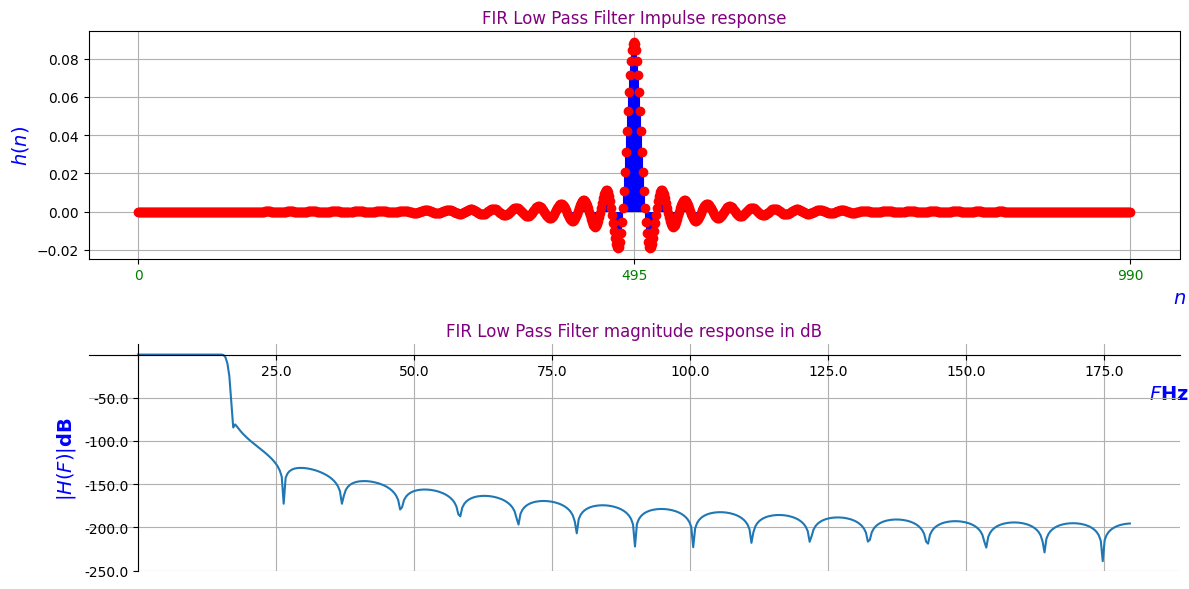

In [ ]:
# Calculate FIR filter coefficients
ncoeffLP = signal.firwin(MLP, FcLP, window = 'blackman', fs = Fs, pass_zero=True)
# Calculate frequency response of designed filter
w, HWLP = signal.freqz(ncoeffLP, fs = Fs)

# Plot Impulse response and frequency response of filter
plt.figure(figsize = (12,6)) # 10 in by 5 in
plt.subplot(211)
plt.stem(ncoeffLP, linefmt='blue', markerfmt='ro', use_line_collection = True, basefmt=" ")
plt.title("FIR Low Pass Filter Impulse response", color ="purple")
plt.ylabel('$h(n)$', fontsize=14, color="blue", weight="bold") # Could use rotation=0
plt.xlabel('$n$', fontsize=14, color="blue",  x=1.0)
plt.xticks([0,MidMLP,MLP-1], color="green")
#plt.yticks([-0.01,0.048,0.05])
# plt.axis([0,MLP-1,-0.015,0.05])
plt.grid(True)

plt.subplot(212)
plt.plot(w,20*np.log10(np.abs(HWLP)))
plt.title("FIR Low Pass Filter magnitude response in dB", color ="purple")
plt.ylabel('$|H(F)|$dB', fontsize=14, color="blue", weight="bold")
plt.xlabel('$F$Hz', fontsize=14, color="blue", weight="bold",  x=0.99)
layout.cross_spines(zero_cross=True)
# plt.yticks([-150,-125,-100,-75,-50,-25,-6,0])
# plt.xticks([44,50,125], color="green")
plt.tight_layout() # ensure sufficient spacing between subplots
plt.grid(True)

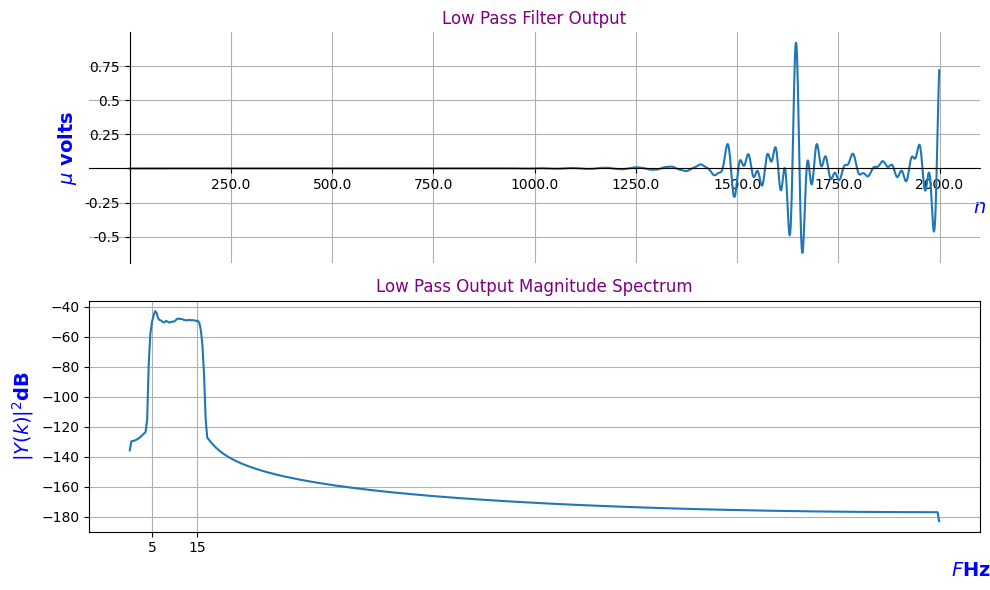

In [ ]:
# Apply Low pass filter to already high pass filtered signal
ecg_LPoutput = signal.lfilter(ncoeffLP, [1.0], ecg_HPoutput)
# Calculate spectral estimation using welch method
f, ecg_LPoutputwelch =  signal.welch(ecg_LPoutput, Fs, 'hamming', nperseg=1024, detrend=False)

# Plot output signal and frequency content of filtered signal
plt.figure(figsize = (10,6)) # 10 in by 6 in
plt.subplot(211)
plt.plot(ecg_LPoutput[0:2000])
plt.title("Low Pass Filter Output", color ="purple")
plt.ylabel('$\mu$ volts', fontsize=14, color="blue", weight="bold")
plt.xlabel('$n$', fontsize=14, color="blue", weight="bold",  x=1.0)
layout.cross_spines(zero_cross=True)
plt.grid(True)

plt.subplot(212)
plt.plot(f, 20*np.log10(ecg_LPoutputwelch))
plt.title("Low Pass Output Magnitude Spectrum", color ="purple")
plt.ylabel('$|Y(k)|^2$dB', fontsize=14, color="blue", weight="bold")
plt.xlabel('$F$Hz', fontsize=14, color="blue", weight="bold",  x=0.98)
plt.xticks([5,15])
# plt.axis([0, 125,-120,50])
plt.grid(True)
plt.tight_layout() # ensure sufficient spacing between subplots


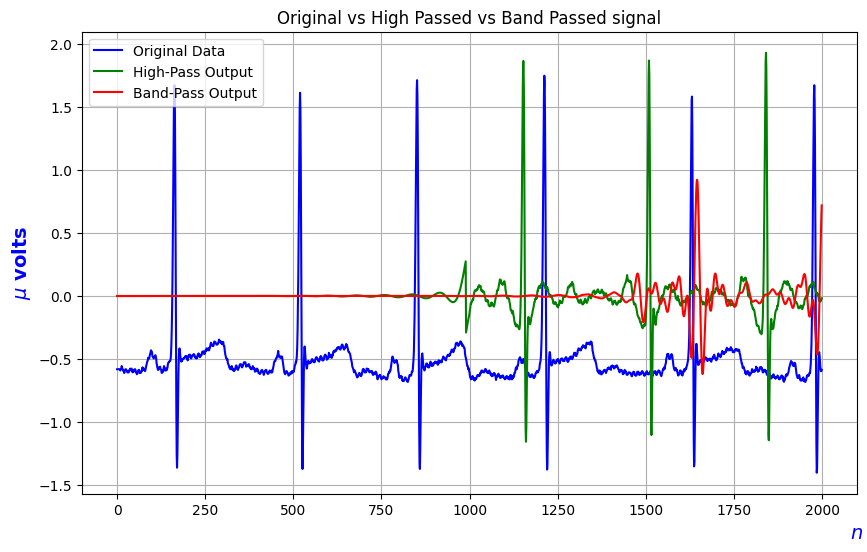

In [ ]:
# Plot original signal along with filter outputs after high and low pass filters applied

plt.figure(figsize = (10,6))
plt.title('Original vs High Passed vs Band Passed signal')
plt.ylabel('$\mu$ volts', fontsize=14, color="blue", weight="bold")
plt.xlabel('$n$', fontsize=14, color="blue", weight="bold",  x=1.0)
plt.plot(ecg_data[0:2000],'blue')
plt.plot(ecg_HPoutput[0:2000], 'green')
plt.plot(ecg_LPoutput[0:2000], 'red');
plt.grid(True)
plt.legend(['Original Data', 'High-Pass Output', 'Band-Pass Output'])

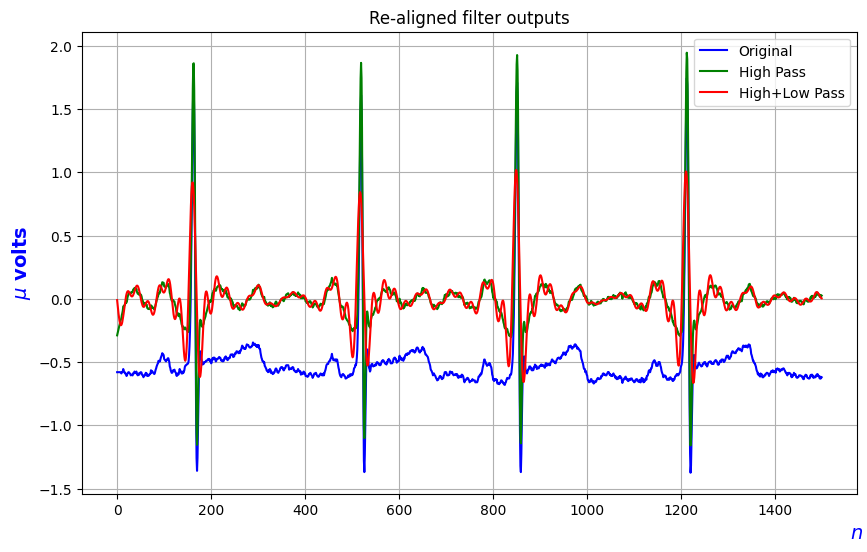

In [ ]:
# Plot three signals again after realigning offset due to group delay

numPoints = 1500

plt.figure(figsize = (10,6))
plt.title('Re-aligned filter outputs')
plt.ylabel('$\mu$ volts', fontsize=14, color="blue", weight="bold")
plt.xlabel('$n$', fontsize=14, color="blue", weight="bold",  x=1.0)
plt.plot(ecg_data[0:numPoints],  'blue')
plt.plot(ecg_HPoutput[MidM_blackman:numPoints+MidM_blackman], 'green')
plt.plot(ecg_LPoutput[MidM_blackman+MidMLP:numPoints+MidM_blackman+MidMLP], 'red');
plt.legend(("Original", "High Pass", "High+Low Pass"))
plt.grid(True)

## Passband lowered to 0.5 - 15 Hz

By changing the lower cut-off of the passband to be 0.5Hz, the transition bandwidth is forced down to a value less than or equal to 0.5Hz as it is not possible to have a bandwidth that extends lower than 0 Hz.

Once again, due to the relationship between filter length and transition bandwidth, reducing Δf to such a small value greatly increases the filter length and thus the delay introduced from the filter. Where the delay is determined by

\begin{align}
  \frac{M-1}{2}
\end{align}

For instance, employing an FIR filter via the same method as before would result in a filter length of **3961**. With the group delay being $\frac{M-1}{2}$ the delay imposed by this filter would be **1980** or **5.5 seconds**. In a real time application this is quite long and may be unacceptable in terms of performance

In [ ]:
new_deltaHPF = 0.5 #### Transition Bandwidth in Hz
new_HPPassbandF = 0.5  #### Passband Edge Frequency in Hz
FcHP = new_HPPassbandF - new_deltaHPF/2   ##### Cutoff Frequency in Hz ()

M_blackman = int(np.ceil(5.5 * Fs/new_deltaHPF)) # Filter Length for Blackman Window
M_blackman = M_blackman + 1 if M_blackman % 2 == 0 else M_blackman # Ensure filter length is odd
group_delay = int((M_blackman - 1) / 2)
time_delay = group_delay/Fs
print(f"M_blackman = {M_blackman}")
print(f"Group Delay = {group_delay}")
print(f"Time delay = {time_delay} seconds")

M_blackman = 3961
Group Delay = 1980
Time delay = 5.5 seconds


# Alternative approach
An alternative approach which combats this restriction is the utilisation of an Infinite Impluse Response (IIR) Filter instead of the as seen so far Finite Impulse Response (FIR) Filters.

The Scipy function _cheby1_ was used to create a chebychev IIR High Passfilter with a cutoff of 0.5Hz

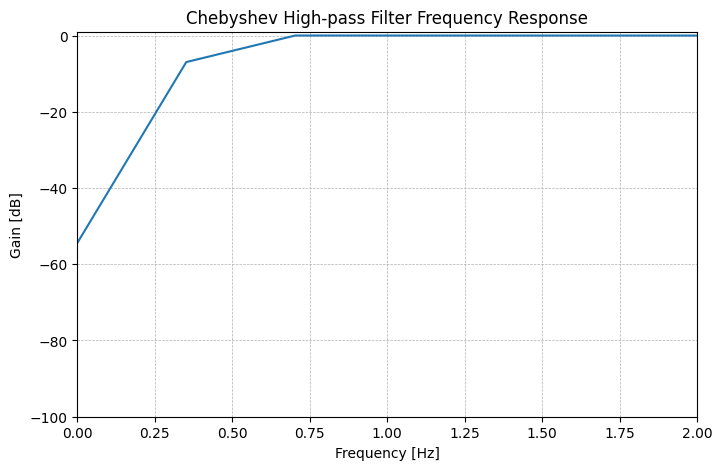

In [ ]:
delta_IIR_HPF = 2 #### Transition Bandwidth in Hz
FcLP = LPPassbandF + deltaLPF/2   ##### Cutoff Frequency in Hz ()

# High-pass filter design parameters
delta_IIR_HPF = 0.1
f_IIR_HP = 0.5 # in Hz
f_c = f_IIR_HP - delta_IIR_HPF/2
order = 6  # Chebyshev filter order

# Design the high-pass Chebyshev filter
b, a = signal.cheby1(N=order,rp = 0.01, Wn=f_c, btype='highpass', analog=False, output='ba', fs=Fs)

# Frequency response of the filter
w, h = signal.freqz(b, a, fs=Fs)

plt.figure(figsize = (8,5)) # 10 in by 5 in
plt.plot(w, 20*np.log10(abs(h)))
plt.title('Chebyshev High-pass Filter Frequency Response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain [dB]')
plt.grid(which='both', axis='both', linestyle='--', linewidth=0.5)
plt.axis([0,2,-100,1])

plt.show()


The filter's frequency response above shows the desired output with frequencies below 0.5 Hz being strongly attenuated



## Applying IIR Filter

It can be seen in the plots below that the ECG data has been filtered to attenuate frequencies below 0.5Hz while maintaining zero delay in the output signal. This is far more useful to applications that require real time filtering.

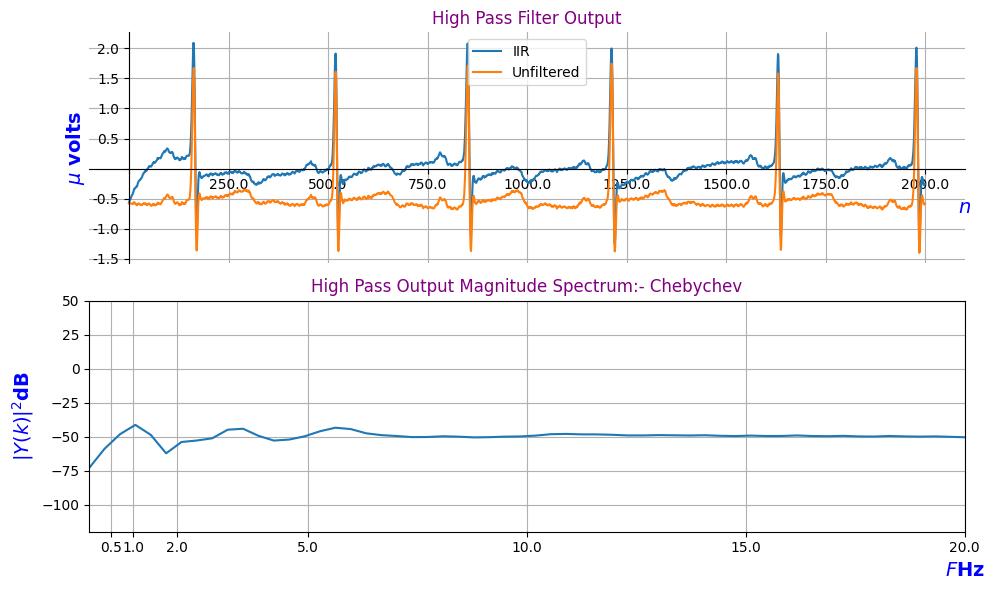

In [ ]:
# Apply IIR filter to input ECG Data
ecg_IIR_HPoutput = signal.lfilter(b, a, ecg_data)

# Perform welchs method to get spectral estimation of filtered signal
f_IIR, ecg_IIR_HPoutputwelch =  signal.welch(ecg_IIR_HPoutput, Fs, 'blackman', nperseg=1024, detrend=False)

plt.figure(figsize = (10,6)) # 10 in by 6 in
plt.subplot(211)
plt.plot(ecg_IIR_HPoutput[0:2000])
plt.plot(ecg_data[0:2000])
plt.title("High Pass Filter Output", color ="purple")
plt.ylabel('$\mu$ volts', fontsize=14, color="blue", weight="bold")
plt.xlabel('$n$', fontsize=14, color="blue", weight="bold",  x=1.0)
plt.legend(["IIR", "Unfiltered"])
layout.cross_spines(zero_cross=True)


plt.subplot(212)
plt.plot(f_IIR, 20*np.log10(ecg_IIR_HPoutputwelch))
plt.title("High Pass Output Magnitude Spectrum:- Chebychev", color ="purple")
plt.ylabel('$|Y(k)|^2$dB', fontsize=14, color="blue", weight="bold")
plt.xlabel('$F$Hz', fontsize=14, color="blue", weight="bold",  x=1.0)
plt.xticks([0.5,1,2,5,10,15,20])
plt.axis([0, 20,-120,50])
plt.grid(True)
plt.tight_layout()


# Conclusion

In conclusion, this assignment aimed to analyze and process an ECG signal obtained from the MIT-BIH Arrhythmia Database with a sampling frequency of 360 Hz. The implementation involved the design and evaluation of cascaded high-pass and low-pass FIR filters, as well as an exploration of an alternative IIR filter for lower frequency high pass filtering.

The spectrum analysis of the ECG signal showed the presence of noise components, motivating the need for effective filtering techniques. The application of the Pan Tomkins Algorithm necessitated a bandpass filter with a passband of 5 to 15 Hz to enhance the detection of R-R intervals while mitigating muscle noise, mains interference, baseline wander, and T-wave interference.

The FIR filter design employed the window method with a blackman window. It was successfully implemented and the desired bandpass filtering was achieved. Time domain simulations and frequency response analyses demonstrated the effectiveness of the FIR filter in achieving the specified passband.

Furthermore, a variation in the passband to 0.5 to 15 Hz was investigated to assess the real-time application of the FIR filter. It was shown that in real time applications FIR filters fall down due to the group delay introduced by the filter length. An alternative approach to bandpass filtering was explored, simulated, and its frequency response and output spectrum analyzed. This investigation provided valuable insights into the adaptability and performance of the FIR filter under different passband configurations.

In summary, the assignment successfully achieved its objectives by implementing and analyzing FIR and IIR filters for ECG signal processing.